In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

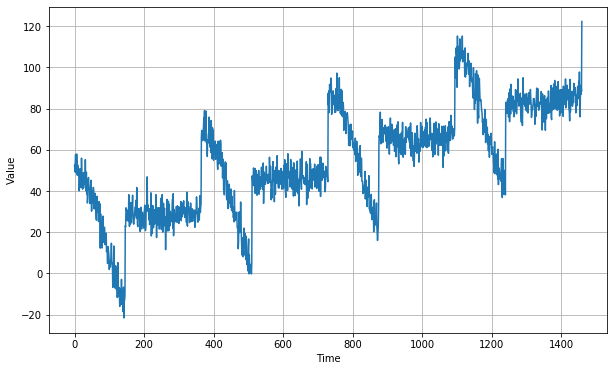

In [3]:
# Ploting the sequence
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
# Splitting the data
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
# Preprocessing with 1D CNN layer and dilation rates
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
8/8 [==============================] - 7s 826ms/step - loss: 42.1616 - mae: 42.7348
Epoch 2/100
8/8 [==============================] - 1s 137ms/step - loss: 41.7653 - mae: 42.3306
Epoch 3/100
8/8 [==============================] - 1s 159ms/step - loss: 41.3695 - mae: 41.9354
Epoch 4/100
8/8 [==============================] - 1s 134ms/step - loss: 40.9394 - mae: 41.5082
Epoch 5/100
8/8 [==============================] - 2s 189ms/step - loss: 40.4001 - mae: 40.9755
Epoch 6/100
8/8 [==============================] - 2s 219ms/step - loss: 39.6413 - mae: 40.2289
Epoch 7/100
8/8 [==============================] - 1s 135ms/step - loss: 38.4824 - mae: 39.0938
Epoch 8/100
8/8 [==============================] - 1s 123ms/step - loss: 36.5077 - mae: 37.1659
Epoch 9/100
8/8 [==============================] - 1s 118ms/step - loss: 33.0837 - mae: 33.8174
Epoch 10/100
8/8 [========================

[0.0001, 0.1, 0, 30]

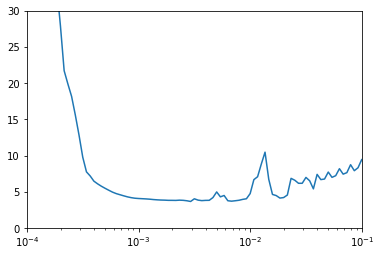

In [6]:
# Ploting the loss
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [7]:
# Train using a checkpoint
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=5)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 8s 947ms/step - loss: 40.0589 - mae: 40.6938 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 2s 256ms/step - loss: 37.9619 - mae: 38.6161 - val_loss: 67.7241 - val_mae: 68.4603
Epoch 3/500
8/8 [==============================] - 2s 290ms/step - loss: 34.9012 - mae: 35.6013 - val_loss: 60.6155 - val_mae: 61.3161
Epoch 4/500
8/8 [==============================] - 1s 157ms/step - loss: 30.5038 - mae: 31.2724 - val_loss: 49.9539 - val_mae: 50.6020
Epoch 5/500
8/8 [==============================] - 1s 142ms/step - loss: 24.6512 - mae: 25.4013 - val_loss: 36.5816 - val_mae: 37.0504
Epoch 6/500
8/8 [==============================] - 1s 179ms/step - loss: 20.1022 - mae: 20.6263 - val_loss: 31.9513 - val_mae: 32.4874
Epoch 7/500
8/8 [==============================] - 2s 300ms/step - loss: 18.8707 - mae: 19.3616 - val_loss: 29.9117 - val_mae: 30.4447
Epoch 8/500
8/8 [==============================] 

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


[0.0001, 0.1, 0, 30]

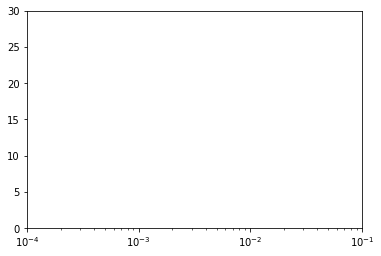

In [18]:
print(history.history.keys())

# Ploting the loss
plt.semilogx(history.history["mae"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [19]:
# Get the best model
model = keras.models.load_model("my_checkpoint.h5")

AttributeError: 'str' object has no attribute 'decode'

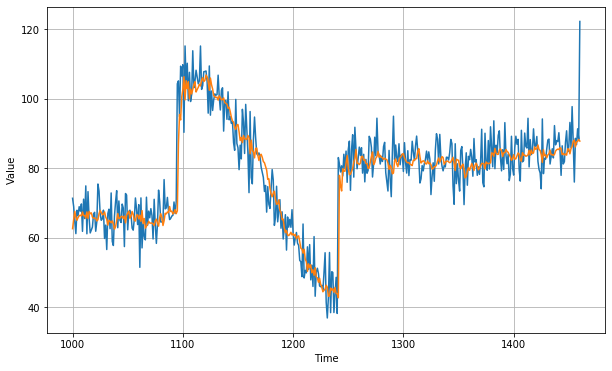

In [20]:
# Forecast
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [21]:
# Print the error
error = keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()
print(error)

4.579586
